In [14]:
#Importing Necessary Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#uploading datasets

transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')
customers = pd.read_csv('Customers.csv')

In [3]:
# Merge datasets
transactions_products = transactions.merge(products, on="ProductID", how="left")
full_data = transactions_products.merge(customers, on="CustomerID", how="left")

In [4]:
# Aggregate transaction history by customer
customer_transactions = full_data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    total_quantity=("Quantity", "sum"),
    avg_transaction_value=("TotalValue", "mean"),
    transaction_count=("TransactionID", "count")
).reset_index()

In [5]:
# Merge with customer profiles
customer_profiles = customers.merge(customer_transactions, on="CustomerID", how="left")

In [6]:
# Fill missing values with 0 (e.g., for customers with no transactions)
customer_profiles = customer_profiles.fillna(0)

In [7]:
# Prepare data for clustering
features = customer_profiles.drop(columns=["CustomerID", "CustomerName", "SignupDate", "Region"])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [8]:
# Perform clustering and calculate DB Index
cluster_results = {}
db_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    cluster_results[k] = labels
    db_scores.append((k, db_index))

In [9]:
# Choose the best number of clusters (lowest DB Index)
best_k, best_db_index = min(db_scores, key=lambda x: x[1])
best_labels = cluster_results[best_k]
customer_profiles["Cluster"] = best_labels

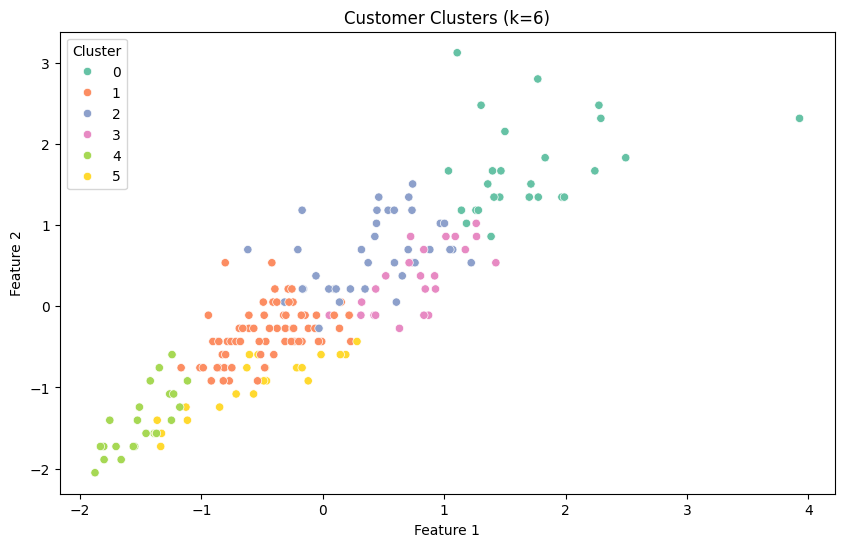

In [11]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=scaled_features[:, 0], 
    y=scaled_features[:, 1], 
    hue=best_labels, 
    palette="Set2", 
    legend="full"
)
plt.title(f"Customer Clusters (k={best_k})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Cluster")
plt.savefig("Cluster_Visualization.png")
plt.show()

In [12]:
# Print DB scores and clusters to report
print("DB Index for Different Clusters:")
for k, db_index in db_scores:
    print(f"Clusters: {k}, DB Index: {db_index:.2f}")

print(f"Optimal number of clusters: {best_k}")
print(f"Davies-Bouldin Index for best clustering: {best_db_index:.2f}")

DB Index for Different Clusters:
Clusters: 2, DB Index: 0.94
Clusters: 3, DB Index: 1.08
Clusters: 4, DB Index: 0.93
Clusters: 5, DB Index: 0.94
Clusters: 6, DB Index: 0.91
Clusters: 7, DB Index: 0.94
Clusters: 8, DB Index: 1.02
Clusters: 9, DB Index: 0.94
Clusters: 10, DB Index: 0.96
Optimal number of clusters: 6
Davies-Bouldin Index for best clustering: 0.91


In [13]:
# Print cluster assignments
print("Cluster Assignments:")
print(customer_profiles[["CustomerID", "Cluster"]].head())

Cluster Assignments:
  CustomerID  Cluster
0      C0001        1
1      C0002        1
2      C0003        1
3      C0004        0
4      C0005        1
